In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_data, get_preds, get_table
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=800)
train["propleft"] = 1 - train["prop"]
test["propleft"] = 1 - test["prop"]
train["propxcurr"] = train["prop"] * train["curr_pace"]
test["propxcurr"] = test["prop"] * test["curr_pace"]

train['male'] = train['gender'].apply(lambda x: 1 if x == 'M' else 0)
test['male'] = test['gender'].apply(lambda x: 1 if x == 'M' else 0)
train.to_csv("train.csv")
test.to_csv("test.csv")
# test = pd.read_csv("test.csv")

In [2]:
model_info = {
    # "rstan1a" : ("stan_results/rs_result1a.csv", ["total_pace"], ["beta[1]"], False),
    # "rstan1b" : ("stan_results/rs_result1b.csv", ["total_pace", "curr_pace"], ["beta[1]", "beta[2]"], False),
    # "rstan1c" : ("stan_results/rs_result1c.csv", ["total_pace", "prop"],  ["beta[1]", "beta[2]"], False),
    # "rstan1d" : ("stan_results/rs_result1d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], False),

    "rstan2a" : ("stan_results/rs_result2a.csv", ["total_pace"], ["beta[1]"], True),
    "rstan2b" : ("stan_results/rs_result2b.csv", ["total_pace", "curr_pace"],  ["beta[1]", "beta[2]"], True),
    "rstan2c" : ("stan_results/rs_result2c.csv", ["total_pace", "prop"], ["beta[1]", "beta[2]"], True),
    "rstan2d" : ("stan_results/rs_result2d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),

    "rstan3a" : ("stan_results/rs_result3a.csv", ["total_pace", "curr_pace", "prop", "propxcurr"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]"], True),
    "rstan3b" : ("stan_results/rs_result3b.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),

    "rstan3c" : ("stan_results/rs_result_1.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
}

models = {k: pd.read_csv(v[0]) for k, v in model_info.items()}

In [3]:
model_preds = {}

for k, v in model_info.items():
    print(k, v)
    preds = get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3])
    model_preds[k] = preds

rstan2a ('stan_results/rs_result2a.csv', ['total_pace'], ['beta[1]'], True)
rstan2b ('stan_results/rs_result2b.csv', ['total_pace', 'curr_pace'], ['beta[1]', 'beta[2]'], True)
rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)
rstan3c ('stan_results/rs_result_1.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [4]:
s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .5]], columns=["total_pace", "prop", "propleft"])
get_preds(s_data, models['rstan2c'], feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], full=True)

array([[3.45770303, 3.55477524, 3.79704851, ..., 4.06882452, 3.66620499,
        3.83660419],
       [3.22510181, 2.92149195, 2.98748099, ..., 3.31446892, 3.35505188,
        3.12658626]])

In [5]:
test2 = test.copy()
for k, v in model_preds.items():
    test2[k] = get_table(v)["stan"]
test2["extrap"] = get_table(model_preds["rstan3a"])["extrap"]
test2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,propxcurr,male,rstan2a,rstan2b,rstan2c,rstan2d,rstan3a,rstan3b,rstan3c,extrap
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,0.610812,1,-2.749957,-3.074199,3.125611,3.381057,0.225403,0.326398,-2.593411,-3.702833
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,0.554244,0,6.364172,6.153992,14.187077,13.776766,11.317967,10.928171,7.870106,5.388183
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,0.580301,1,-1.869484,-1.715348,4.925535,5.181977,2.373869,2.014273,-0.790333,-2.696350
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,0.606435,1,-10.804620,-11.080077,-4.662665,-4.146421,-7.247795,-7.368764,-10.283206,-11.551617
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,0.547080,1,4.087541,3.171090,11.857509,11.900799,9.217639,8.938992,5.669131,2.940617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,1.546459,0,1.582373,2.873383,0.425720,1.884051,1.246600,0.427022,0.966012,-0.910996
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,1.638402,0,-0.291726,-0.394418,-1.500941,-1.496824,-2.039218,-2.859898,-2.311956,-2.888940
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.052020,1.605113,1,-0.464272,-0.141159,-1.579733,-1.174676,-1.766435,-1.871906,-1.281567,-2.965773
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.052020,1.356971,1,-2.281654,1.575712,-3.368702,1.322273,0.551936,0.396643,0.726395,-4.780504


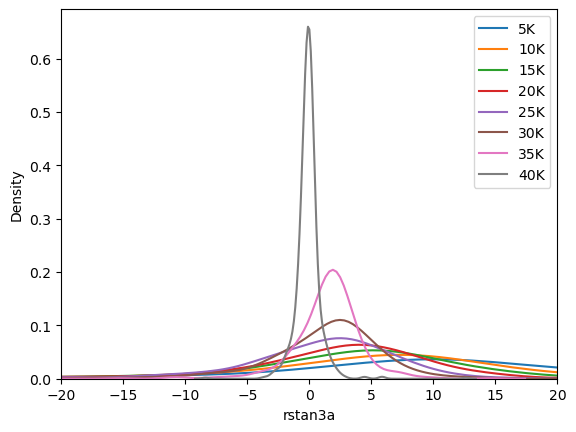

In [6]:
import seaborn as sns
marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
for mark in marks:
    sns.kdeplot(test2[test2["dist"] == mark]["rstan3a"], label=mark)
plt.xlim(-20, 20)
plt.legend()

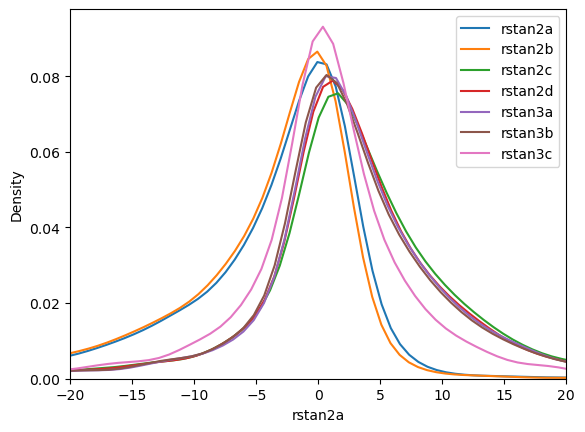

In [7]:
for m in model_info.keys():
    sns.kdeplot(test2[m], label=m)

plt.xlim(-20, 20)
plt.legend()

         extrap    rstan3a    rstan3b    rstan2c    rstan2d
dist                                                       
5K    18.266615  17.944921  17.836517  17.526959  17.365875
10K   17.293082  13.645630  13.557492  13.822974  13.528029
15K   15.891527  11.174082  11.102838  11.560812  11.283393
20K   13.460085   9.013676   8.958126   9.460044   9.112207
25K   11.258575   7.230871   7.202962   7.745990   7.349823
30K    7.920076   5.352851   5.278029   5.827423   5.305353
35K    4.376820   3.445891   3.329382   3.836403   3.328255
40K    1.179431   1.034428   1.103892   1.154561   1.040881


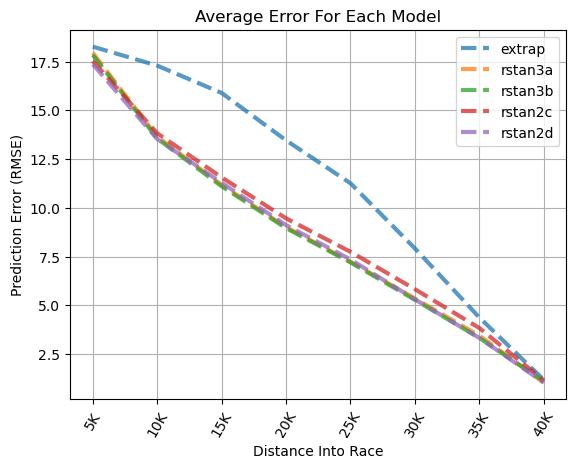

In [8]:
labels = ["extrap", "rstan2a", "rstan2b", "rstan2c", "rstan2d"]
labels = ["extrap", "rstan3a", "rstan3b", "rstan2c", "rstan2d"]

colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table_group = test2.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table_group)
table_group.plot(label=table_group.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
plt.savefig("analysis/all_errors3.png", bbox_inches="tight")

In [9]:
model_preds2 = {}

for k, v in model_info.items():
    print(k, v)
    preds = (42195 / 60) / get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3], full=True)
    model_preds2[k] = preds

rstan2a ('stan_results/rs_result2a.csv', ['total_pace'], ['beta[1]'], True)
rstan2b ('stan_results/rs_result2b.csv', ['total_pace', 'curr_pace'], ['beta[1]', 'beta[2]'], True)
rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)
rstan3c ('stan_results/rs_result_1.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [10]:
model_preds2['rstan2a']

array([[145.81506718, 138.67572303, 157.9871396 , ..., 137.66992281,
        138.50738757, 142.87453437],
       [129.9853674 , 150.32703132, 144.49351351, ..., 167.30475208,
        159.43669754, 141.78737076],
       [138.63915413, 159.77796962, 149.39615814, ..., 144.46782884,
        150.52533936, 142.6172133 ],
       ...,
       [359.50822999, 353.26052034, 364.96372413, ..., 362.07486098,
        361.28543842, 360.83632759],
       [364.27551502, 360.60833765, 369.86191501, ..., 364.73816868,
        358.71852639, 359.35323214],
       [375.30125976, 385.01723045, 381.95819333, ..., 387.32295137,
        380.50224442, 377.97528839]])

In [11]:
def add_intervals_to_test(data_tbl, preds1, preds2, preds3, preds4):#, q1, q2):
    data = data_tbl.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / data["finish"]
        b11, b12 = np.percentile(preds1, [lower, upper], axis=1)
        data[f"stan1-lower{conf}"] = b11
        data[f"stan1-upper{conf}"] = b12
        data[f"stan1-size{conf}"] = b12 - b11
        data[f"stan1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(preds2, [lower, upper], axis=1)
        data[f"stan2-lower{conf}"] = b21
        data[f"stan2-upper{conf}"] = b22
        data[f"stan2-size{conf}"] = b22 - b21
        data[f"stan2-in{conf}"] = (test_true < b22) & (test_true > b21)

        b31, b32 = np.percentile(preds3, [lower, upper], axis=1)
        data[f"stan3-lower{conf}"] = b31
        data[f"stan3-upper{conf}"] = b32
        data[f"stan3-size{conf}"] = b32 - b31
        data[f"stan3-in{conf}"] = (test_true < b32) & (test_true > b31)

        b41, b42 = np.percentile(preds4, [lower, upper], axis=1)
        data[f"stan4-lower{conf}"] = b41
        data[f"stan4-upper{conf}"] = b42
        data[f"stan4-size{conf}"] = b42 - b41
        data[f"stan4-in{conf}"] = (test_true < b42) & (test_true > b41)

    return data

In [12]:
preds1, preds2, preds3, preds4 = model_preds2["rstan2a"], model_preds2["rstan2b"], model_preds2["rstan2c"], model_preds2["rstan2d"]
# preds1, preds2, preds3, preds4 = model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"]
# preds1, preds2, preds3, preds4 = model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"]
table2 = add_intervals_to_test(test2, preds1, preds2, preds3, preds4)
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,...,stan2-size95,stan2-in95,stan3-lower95,stan3-upper95,stan3-size95,stan3-in95,stan4-lower95,stan4-upper95,stan4-size95,stan4-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,...,32.991834,True,129.921458,160.009923,30.088465,True,130.719686,158.281529,27.561843,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,...,41.364131,True,142.164334,179.494656,37.330323,True,143.486669,178.072270,34.585601,True
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,...,37.003454,True,136.314934,169.671069,33.356135,True,137.425762,168.588204,31.162443,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,...,33.617091,True,130.797058,161.962773,31.165715,True,132.047154,159.629210,27.582056,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,...,42.504858,True,144.675555,182.383032,37.707477,True,145.416474,179.367460,33.950986,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,...,13.605874,True,354.545811,365.595208,11.049397,True,356.275024,366.615904,10.340880,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,...,13.703424,True,353.728654,364.485686,10.757033,True,353.896704,364.106960,10.210256,True
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.052020,...,13.479365,True,354.787942,366.094348,11.306405,True,355.562818,365.857223,10.294405,True
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.052020,...,13.957636,True,353.294769,364.402359,11.107590,True,358.077728,368.503187,10.425458,True


/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

,stan1-in50,stan2-in50,stan3-in50,stan4-in50,stan1-in80,stan2-in80,stan3-in80,stan4-in80,stan1-in95,stan2-in95,stan3-in95,stan4-in95
dist,,,,,,,,,,,,
5K,0.79375,0.77125,0.47875,0.44375,0.94875,0.93750,0.89500,0.84375,0.98750,0.98250,0.99125,0.97625
10K,0.76750,0.73250,0.56375,0.52625,0.93125,0.91625,0.93750,0.90500,0.98250,0.97875,0.99250,0.98625
15K,0.72250,0.68250,0.59000,0.55750,0.91125,0.90125,0.94375,0.92250,0.97875,0.97500,0.98500,0.98125
20K,0.70500,0.65875,0.59500,0.57250,0.90750,0.89000,0.92750,0.91125,0.97500,0.97125,0.98500,0.97750
25K,0.65875,0.62500,0.61500,0.61625,0.89375,0.88125,0.91125,0.90375,0.96500,0.96000,0.97500,0.97250
30K,0.69875,0.69750,0.56875,0.56125,0.90250,0.90625,0.89625,0.89875,0.97125,0.97000,0.97500,0.97250
35K,0.74250,0.82125,0.48250,0.50625,0.93750,0.95625,0.86125,0.91250,0.97625,0.98125,0.97000,0.97750
40K,0.35500,0.60875,0.48875,0.71625,0.75750,0.93500,0.84375,0.91375,0.96625,0.98375,0.96750,0.97875


<Figure size 4000x4000 with 0 Axes>

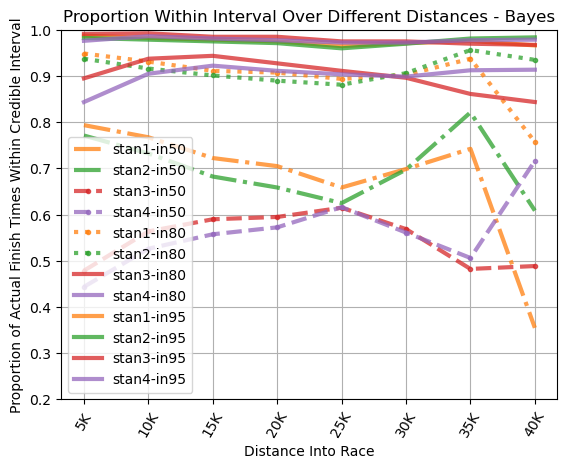

In [13]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-in{conf}", f"stan2-in{conf}", f"stan3-in{conf}", f"stan4-in{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
# plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")
big_table

<Figure size 3000x2000 with 0 Axes>

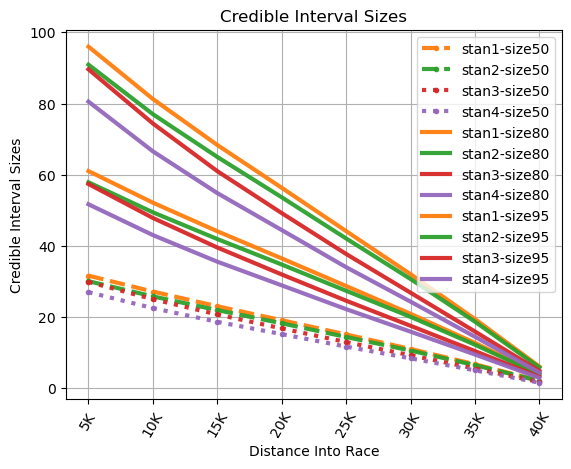

In [14]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-size{conf}", f"stan2-size{conf}", f"stan3-size{conf}", f"stan4-size{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
plt.savefig("analysis/interval_sizes_bayes2.png", bbox_inches="tight")
